In [104]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
import pandas as pd
from scipy.stats import binned_statistic

In [11]:
from lsst.daf.butler import Butler

In [21]:
%matplotlib widget

In [12]:
butler = Butler('/repo/main', collections='u/csaunder/DM-42519')

In [13]:
single_band_outputs = glob('/scratch/users/c/csaunder/submit/u/csaunder/DM-42519_baselineRerun/*/jobs/'
                   'gbdesAstrometricFit/*/*/*out')

multiband_outputs = glob('/scratch/users/c/csaunder/submit/u/csaunder/DM-42519/20240503T200844Z/jobs/'
                   'gbdesAstrometricMultibandFit/*/*out')


In [14]:
def processOutput(filename):
    file_details = filename.split('/')
    if len(file_details) == 15:
        tract = int(filename.split('/')[-3])
        run = filename.split('/')[-6]
        band = file_details[-2]
    else:
        tract = int(file_details[-2])
        run = file_details[-5]
        band = 'All'
        
    run = run[:8] + run[9:-1]
    with open(filename) as f:
        lines = f.readlines()
        if len(lines) < 10:
            print(filename, tract, 'failed')
            return tract, run, -1, -1, -1, -1, -1
        if len(file_details) == 15:
            averageResultsStr = lines[-4:]
        else:
            if 'noY' in filename:
                averageResultsStr = lines[-8:-4]
            else:
                averageResultsStr = lines[-9:-5]
        averageResults = np.array([line.split() for line in averageResultsStr])

    if len(file_details) == 15:
        visitResults = np.genfromtxt(filename, skip_header=5, skip_footer=4)
    else:
        if 'noY' in filename:
            visitResults = np.genfromtxt(filename, skip_header=5, skip_footer=8)
        else:
            visitResults = np.genfromtxt(filename, skip_header=5, skip_footer=9)
    fitResults = visitResults[::2]
    validationResults = visitResults[1::2]
    
    nVisits = len(visitResults) / 2 - 1
    fitChiRed = visitResults[::2, -1]
    reserveChiRed = visitResults[1::2, -1]
    
    refFitChiRed = averageResults[0, -1]
    refReserveChiRed = averageResults[1, -1]
    detFitChiRed = averageResults[2, -1]
    detReserveChiRed = averageResults[3, -1]
    if float(detReserveChiRed) > 60:
        print(filename, detReserveChiRed)
    return tract, run, band, nVisits, fitResults, validationResults, refFitChiRed, refReserveChiRed, detFitChiRed, detReserveChiRed

In [15]:
single_results = [processOutput(file) for file in single_band_outputs]
multiband_results = [processOutput(file) for file in multiband_outputs]

In [19]:
single_stacked_results = {9615: [], 9813: [], 9697: []}
single_stacked_validation = {9615: [], 9813: [], 9697: []}
band_visits = {}
for res in single_results:
    single_stacked_results[res[0]].append(res[4])
    single_stacked_validation[res[0]].append(res[5])
    if res[2] in band_visits:
        band_visits[res[2]].append(res[4][:,1])
    else:
        band_visits[res[2]] = [res[4][:,1]]
for k, v in single_stacked_results.items():
    single_stacked_results[k] = np.vstack(v)
for k, v in single_stacked_validation.items():
    single_stacked_validation[k] = np.vstack(v)
for k, v in band_visits.items():
    band_visits[k] = np.concatenate(v)

dict_keys(['HSC-I', 'HSC-Y', 'HSC-R', 'HSC-G', 'HSC-Z'])
[36214. 36172. 36170. 36160. 36158. 36148. 36144. 36140. 36180. 36118.
 35974. 35950. 35936. 35906. 35892. 35890. 35870. 36114. 36190. 36182.
 36202. 36262. 36260. 36192. 36240. 36238. 36236. 36258. 36218. 36216.
 36212. 36204. 36234. 36762. 34942. 36758. 36756. 36754. 36750. 36738.
 34946. 34944. 34874. 36726. 36772. 36768. 36776. 36778. 36788. 36790.
 36792. 36794. 36800. 36802. 36730. 36808. 36812. 36818. 36820. 36828.
 36830. 36834. 36836. 36838. 36810. 36774.  7138. 34760. 34644. 34758.
 34734. 34714. 34712. 34708. 34706. 34698. 34690. 34688. 34686. 34676.
 34674. 34672. 34670. 34664. 34652. 34648. 34640. 34772.  6320. 34422.
 34480. 34478. 34468. 34464. 34450. 34448. 34424. 34486. 34414. 34412.
 34402. 34400. 34384. 34382. 34366. 34362. 34342. 34338. 34482. 34484.
 38944. 36432. 38938. 36404. 36408. 36412. 36416. 36434. 36438. 36442.
 36444. 36446. 36448. 36456. 36458. 36460. 36466. 36474. 36430. 36476.
 36488. 36490. 36492

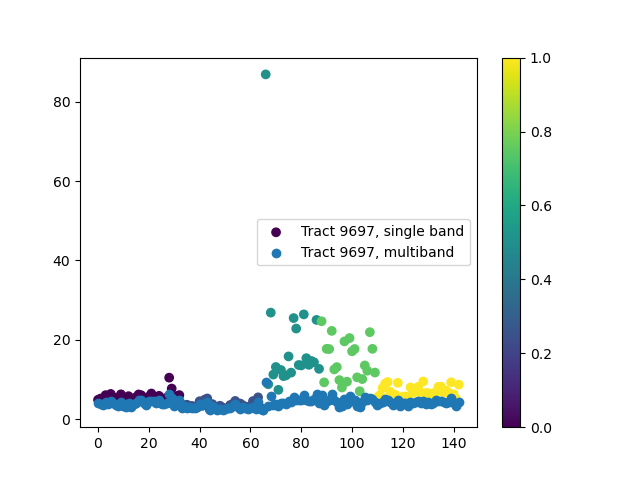

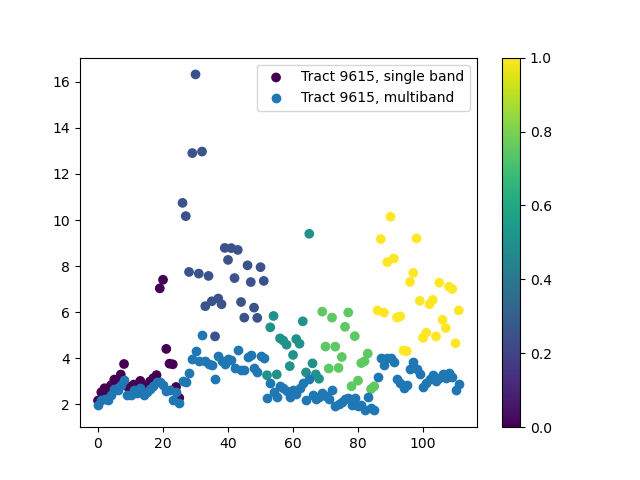

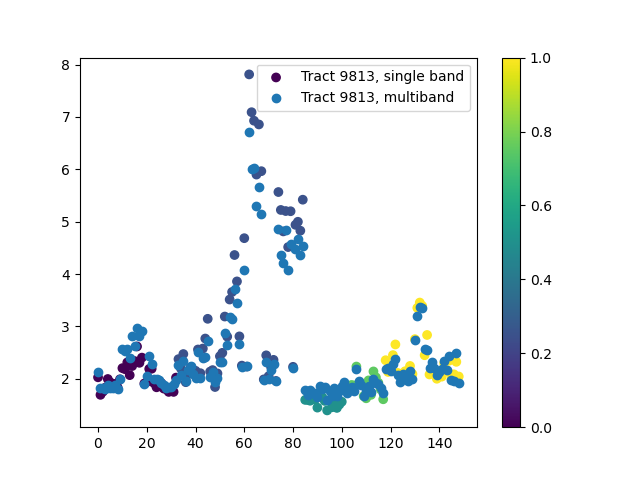

In [24]:
print(band_visits.keys())
for mres in multiband_results:
    plt.figure()
    tract = mres[0]
    sharedVisits, single_intersect, multi_intersect = np.intersect1d(single_stacked_results[tract][:, 1],
                                                                 mres[4][:,1], return_indices=True)
    #print(sharedVisits)
    nvis = np.arange(len(sharedVisits))
    visitBands = np.array([np.flatnonzero([sv in visits for visits in band_visits.values()])[0] for sv in sharedVisits])
    sharedVisits = sharedVisits[visitBands.argsort()]
    single_intersect = single_intersect[visitBands.argsort()]
    multi_intersect = multi_intersect[visitBands.argsort()]  
    visitBands = visitBands[visitBands.argsort()]
    print(sharedVisits)
    plt.scatter(nvis, single_stacked_results[tract][single_intersect, -1], c=visitBands, label=f'Tract {tract}, single band')
    #plt.scatter(single_stacked_results[tract][single_intersect, 4], single_stacked_results[tract][single_intersect, -1], label=f'Tract {tract}, single band')
    plt.scatter(nvis, mres[4][multi_intersect, -1], label=f'Tract {tract}, multiband')
    plt.colorbar()
    #plt.scatter(mres[4][multi_intersect, 4], mres[4][multi_intersect, -1], label=f'Tract {tract}, multiband')
    plt.legend()
    
    #plt.savefig('/home/c/csaunder/stack_projects/RC2_reruns/DM-42519/

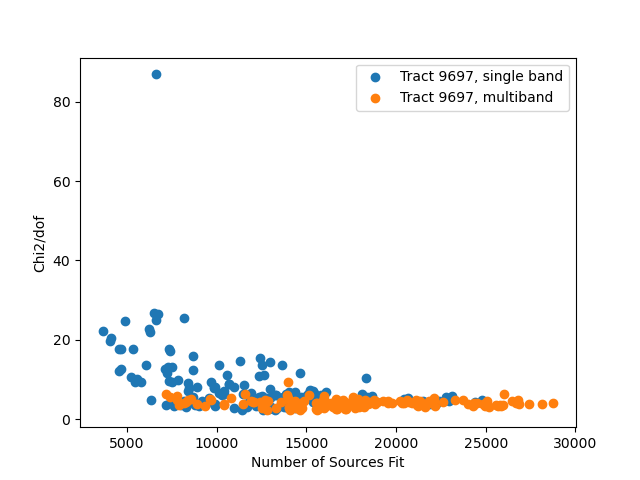

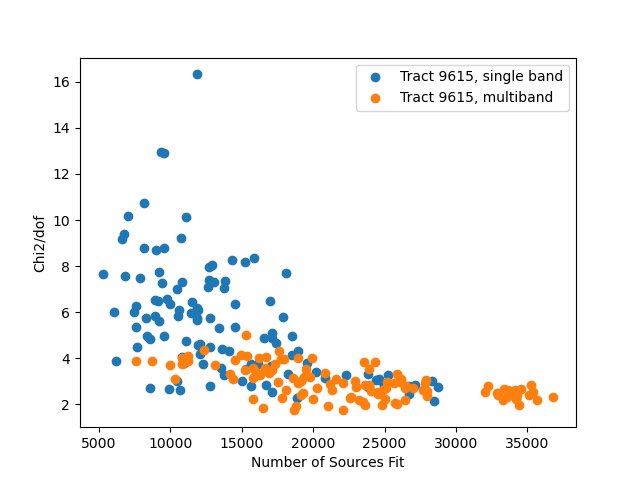

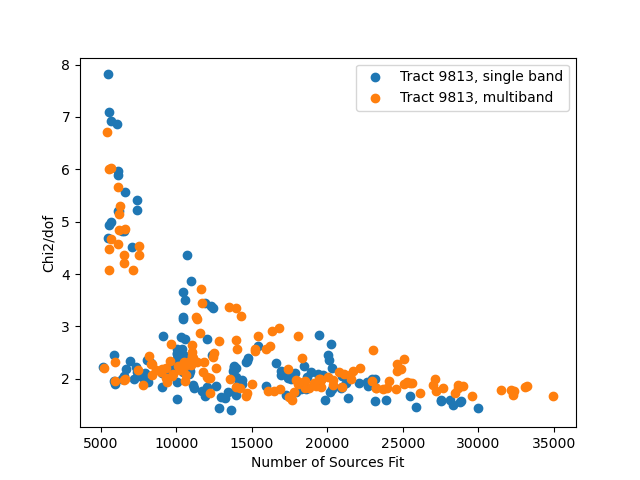

In [28]:
for mres in multiband_results:
    plt.figure()
    tract = mres[0]
    sharedVisits, single_intersect, multi_intersect = np.intersect1d(single_stacked_results[tract][:, 1],
                                                                 mres[4][:,1], return_indices=True)
    #print(sharedVisits)
    nvis = np.arange(len(sharedVisits))
    #plt.scatter(nvis, single_stacked_results[tract][single_intersect, -1], label=f'Tract {tract}, single band')
    plt.scatter(single_stacked_results[tract][single_intersect, 4], single_stacked_results[tract][single_intersect, -1], label=f'Tract {tract}, single band')
    #plt.scatter(nvis, mres[4][multi_intersect, -1], label=f'Tract {tract}, multiband')
    plt.scatter(mres[4][multi_intersect, 4], mres[4][multi_intersect, -1], label=f'Tract {tract}, multiband')
    plt.legend()
    plt.xlabel('Number of Sources Fit')
    plt.ylabel('Chi2/dof')
    plt.savefig(f'/home/c/csaunder/stack_projects/RC2_reruns/DM-42519/nSource_vs_Chi_{tract}.png')

9697
9615
9813
dict_keys(['HSC-I', 'HSC-Y', 'HSC-R', 'HSC-G', 'HSC-Z'])


/tmp/ipykernel_15063/2583071730.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


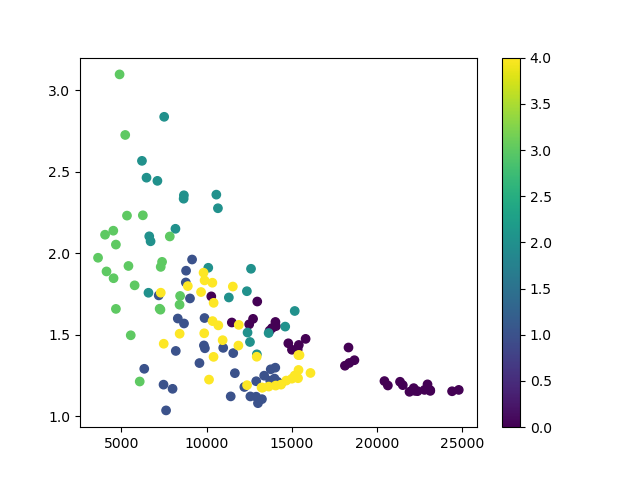

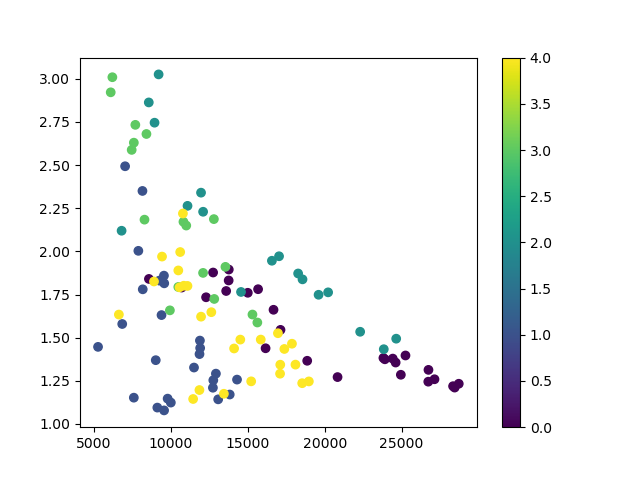

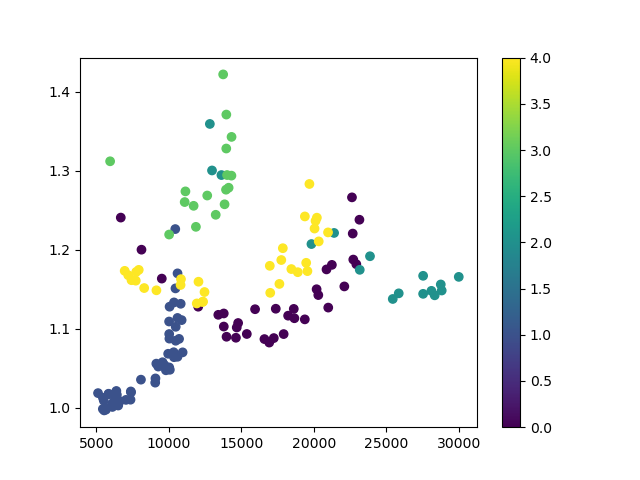

In [29]:
for mres in multiband_results:
    plt.figure()
    tract = mres[0]
    print(tract)
    sharedVisits, single_intersect, multi_intersect = np.intersect1d(single_stacked_results[tract][:, 1],
                                                                 mres[4][:,1], return_indices=True)
    visitBands = np.array([np.flatnonzero([sv in visits for visits in band_visits.values()])[0] for sv in sharedVisits])
    sharedVisits = sharedVisits[visitBands.argsort()]
    single_intersect = single_intersect[visitBands.argsort()]
    multi_intersect = multi_intersect[visitBands.argsort()]  
    visitBands = visitBands[visitBands.argsort()]
    plt.scatter(single_stacked_results[tract][single_intersect, 4],
                mres[4][multi_intersect, 4]/single_stacked_results[tract][single_intersect, 4],
               c=visitBands)
    plt.colorbar()
print(band_visits.keys())

## Look at star catalog uncertainty:

In [45]:
band_visits.keys()

dict_keys(['HSC-I', 'HSC-Y', 'HSC-R', 'HSC-G', 'HSC-Z'])

In [31]:
single_starCats = []
for band in band_visits.keys():
    starCat = butler.get('gbdesAstrometricFit_starCatalog', physical_filter=band, tract=9697, skymap='hsc_rings_v1', 
                         instrument='HSC', collections='u/csaunder/DM-42519_baselineRerun').to_pydict()
    single_starCats.append(pd.DataFrame(starCat))
single_starCovs = []
for sc in single_starCats:
    covs = np.array([np.linalg.inv(np.array(c).reshape(5,5)) for c in sc['starInvCov']])
    single_starCovs.append(covs)

In [32]:
multi_starCatDict = butler.get('gbdesAstrometricMultibandFit_starCatalog', tract=9697, skymap='hsc_rings_v1', 
                            instrument='HSC', collections='u/csaunder/DM-42519')
multi_starCatDict['starInvCov'] = multi_starCatDict['starInvCov'].tolist()
multi_starCat = pd.DataFrame(multi_starCatDict)
multi_starCovs = np.array([np.linalg.inv(np.array(c).reshape(5,5)) for c in multi_starCat['starInvCov']])

In [135]:
multi_starCat

,starMatchID,starReserve,starColor,starPMCount,starDetCount,starClipCount,starDOF,starChisq,starX,starY,starPMx,starPMy,starParallax,starInvCov
0,0,False,-888.0,1,0,1,0,0.000000,-24.445717,0.109011,-2.828230,-13.879494,0.746355,"[75.48807364025214, -9.11264836640524, -2.7709..."
1,1,False,-888.0,1,2,0,4,213.075586,-24.444189,0.162576,-2.260875,-6.246208,1.167787,"[4.734142080276375, -0.103942440599885, -1.398..."
2,2,False,-888.0,1,1,1,2,11.930336,-24.441622,0.206971,-7.132785,0.505133,2.014120,"[95.78319642244527, -15.191573507754693, -18.2..."
3,3,False,-888.0,1,2,0,4,279.639820,-24.436613,0.176019,4.414805,-11.463141,1.525649,"[28.699013403742686, -2.2840522876500082, -9.1..."
4,5,True,-888.0,1,1,0,2,67.884368,-24.435015,0.294843,-10.327957,-9.803540,1.927193,"[5.523482381894609, 0.05731578974692812, -1.85..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397435,398325,True,-888.0,1,2,0,4,17.498911,-19.996952,1.292570,-2.359110,-11.684795,0.291392,"[26.12927225944028, -2.1701075305732282, 0.770..."
397436,398326,True,-888.0,0,3,0,1,21.936461,-19.995577,1.282866,-64.000771,-74.208414,3.933956,"[2.6210360517366897, 0.7897887627547187, 0.054..."
397437,398327,False,-888.0,0,3,0,1,5.830346,-19.993702,1.262823,-121.758735,157.861589,3.740545,"[0.3036740538606204, 0.07534077698514206, 0.01..."
397438,398328,False,-888.0,1,1,0,2,7.681667,-19.993225,1.237329,-1.728720,-0.350222,-5.508381,"[0.8268014994244984, -0.09197247595425828, 0.0..."


In [35]:
objectCatalog = butler.get('objectTable_tract', tract=9697, skymap='hsc_rings_v1',  collections='u/csaunder/DM-42519_baselineRerun',
                          parameters={"columns": ['coord_ra', 'coord_dec', 'i_psfFlux']})
#objectCat = SkyCoord(objectCatalog['coord_ra'], objectCatalog['coord_dec'], unit=u.degree)
#objectMags = (objectCatalog['i_psfFlux'].to_numpy() * u.nJy).to(u.ABmag)

In [36]:
objectCat = SkyCoord(objectCatalog['coord_ra'], objectCatalog['coord_dec'], unit=u.degree)
objectMags = (objectCatalog['i_psfFlux'].to_numpy() * u.nJy).to(u.ABmag)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [37]:
single_starCatalogs = []
for sc in single_starCats:
    sCat = SkyCoord(sc['starX'], sc['starY'], unit=u.degree)
    single_starCatalogs.append(sCat)

In [41]:
multi_starCatalog = SkyCoord(multi_starCat['starX'], multi_starCat['starY'], unit=u.degree)

In [39]:
single_starMags = []
for sc in single_starCatalogs:
    id, d2d, d3d = sc.match_to_catalog_sky(objectCat)
    starMags = np.zeros(len(sc))
    print(len(sc), (d2d.arcsecond < 1).sum())
    starMags[d2d.arcsecond < 1] = objectMags[id[d2d.arcsecond < 1]]
    single_starMags.append(starMags)

179550 67772
110241 35933
86796 35782
57207 20750
121564 41567


In [40]:
id, d2d, d3d = multi_starCatalog.match_to_catalog_sky(objectCat)
multi_starMags = np.zeros(len(multi_starCat))
print(len(multi_starMags), (d2d.arcsecond < 1).sum())
multi_starMags[d2d.arcsecond < 1] = objectMags[id[d2d.arcsecond < 1]]

397440 122530


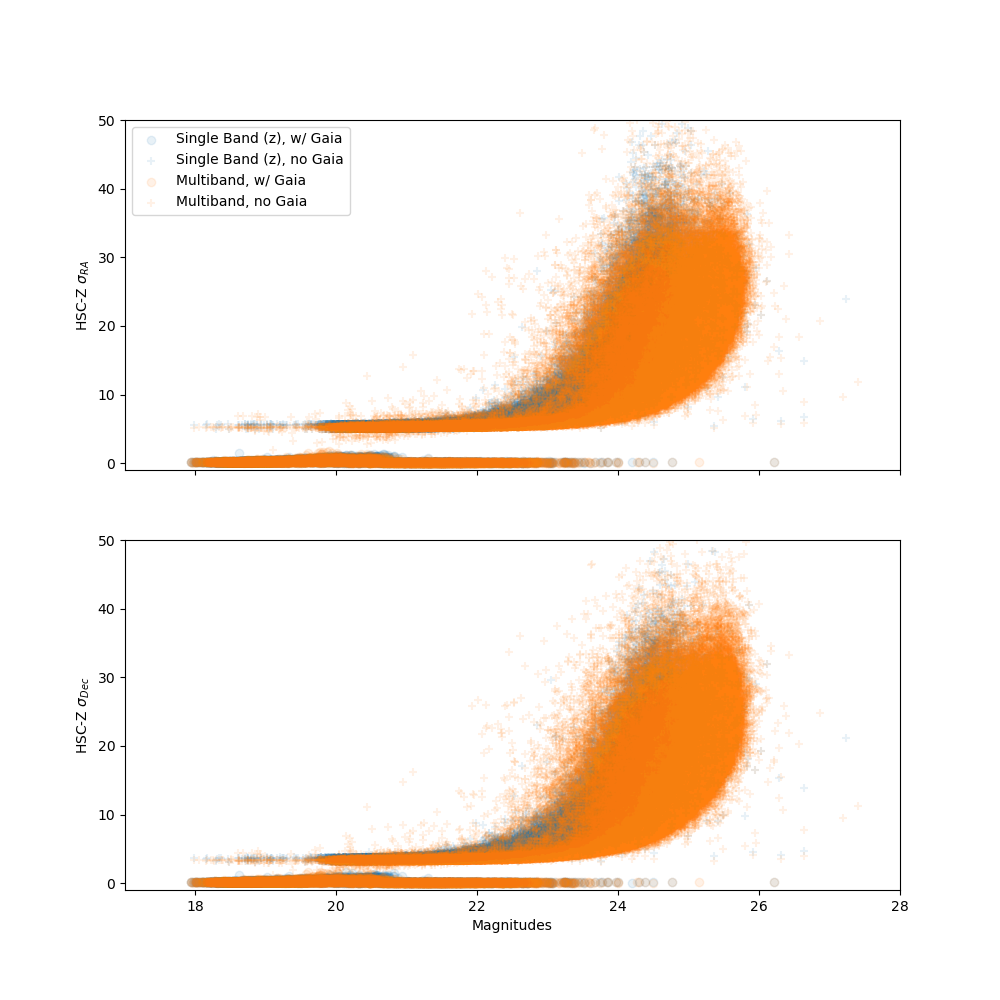

In [150]:
fig, subs = plt.subplots(2, sharex=True, sharey=True, figsize=(10, 10))
ind = (multi_starMags != 0) #& (multi_starCat['starPMCount'] > 0) & (multi_starCat['starDetCount'] > 1)
ind2 = single_starMags[-1] != 0
s1 = subs[0].scatter(single_starMags[-1][ind2 & single_starCats[-1]['starPMCount']], single_starCovs[-1][ind2 & single_starCats[-1]['starPMCount'], 0, 0]**0.5,
                alpha=0.1, label='Single Band (z), w/ Gaia')
subs[0].scatter(single_starMags[-1][ind2 & ~single_starCats[-1]['starPMCount']], single_starCovs[-1][ind2 & ~single_starCats[-1]['starPMCount'], 0, 0]**0.5,
                alpha=0.1, label='Single Band (z), no Gaia', color=s1.get_facecolors()[0].tolist(), marker='+')
subs[0].set_ylabel(f'{band} $\sigma_{{RA}}$')
s1 = subs[1].scatter(single_starMags[-1][ind2 & single_starCats[-1]['starPMCount']], single_starCovs[-1][ind2 & single_starCats[-1]['starPMCount'], 1, 1]**0.5,
                alpha=0.1, label='Single Band (z), w/ Gaia')
subs[1].scatter(single_starMags[-1][ind2 & ~single_starCats[-1]['starPMCount']], single_starCovs[-1][ind2 & ~single_starCats[-1]['starPMCount'], 1, 1]**0.5,
                alpha=0.1, label='Single Band (z), no Gaia', color=s1.get_facecolors()[0].tolist(), marker='+')
subs[1].set_ylabel(f'{band} $\sigma_{{Dec}}$')

s2 = subs[0].scatter(multi_starMags[ind & multi_starCat['starPMCount']], multi_starCovs[ind & multi_starCat['starPMCount'], 0, 0]**0.5,
                     alpha=0.1, label='Multiband, w/ Gaia')
subs[0].scatter(multi_starMags[ind & ~multi_starCat['starPMCount']], multi_starCovs[ind & ~multi_starCat['starPMCount'], 0, 0]**0.5,
                alpha=0.1, label='Multiband, no Gaia', color=s2.get_facecolors()[0].tolist(), marker='+')

s2 = subs[1].scatter(multi_starMags[ind & multi_starCat['starPMCount']], multi_starCovs[ind & multi_starCat['starPMCount'], 1, 1]**0.5,
                     alpha=0.1, label='Multiband, w/ Gaia')
subs[1].scatter(multi_starMags[ind & ~multi_starCat['starPMCount']], multi_starCovs[ind & ~multi_starCat['starPMCount'], 1, 1]**0.5,
                alpha=0.1, label='Multiband, no Gaia', color=s2.get_facecolors()[0].tolist(), marker='+')
#cbar = fig.colorbar(im, ax=subs.ravel().tolist(), shrink=0.95)
subs[1].set_xlim(17, 28)
subs[1].set_ylim(-1, 50)
subs[1].set_xlabel("Magnitudes")
subs[0].legend()
plt.show()

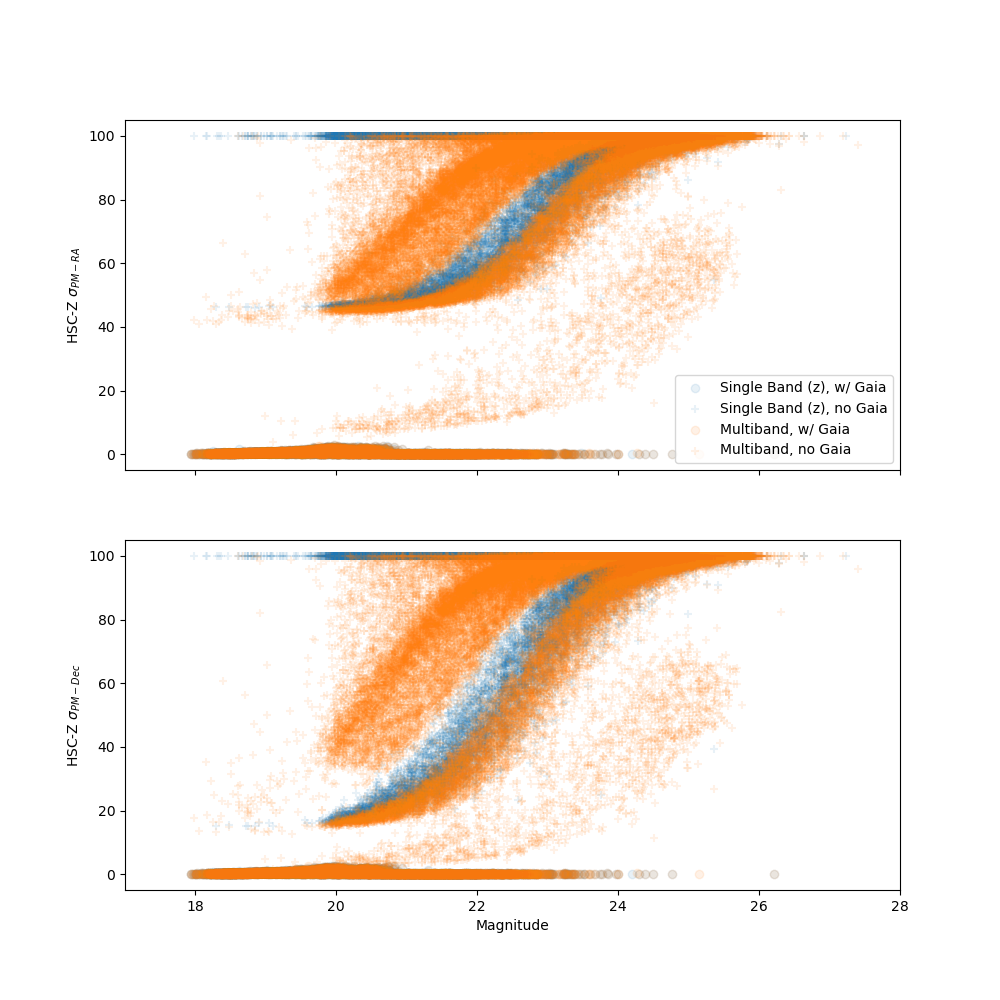

In [151]:
fig, subs = plt.subplots(2, sharex=True, sharey=True, figsize=(10, 10))

ind = single_starMags[-1] != 0
#subs[0].scatter(single_starMags[-1][ind], single_starCovs[-1][ind, 2, 2]**0.5, alpha=0.2, label='Single Band (z)')
subs[0].set_ylabel(f'{band} $\sigma_{{PM-RA}}$')

#subs[1].scatter(single_starMags[-1][ind], single_starCovs[-1][ind, 3, 3]**0.5, alpha=0.2)
subs[1].set_ylabel(f'{band} $\sigma_{{PM-Dec}}$')

s1 = subs[0].scatter(single_starMags[-1][ind & single_starCats[-1]['starPMCount']], single_starCovs[-1][ind & single_starCats[-1]['starPMCount'], 2, 2]**0.5,
                alpha=0.1, label='Single Band (z), w/ Gaia')
subs[0].scatter(single_starMags[-1][ind & ~single_starCats[-1]['starPMCount']], single_starCovs[-1][ind & ~single_starCats[-1]['starPMCount'], 2, 2]**0.5,
                alpha=0.1, label='Single Band (z), no Gaia', color=s1.get_facecolors()[0].tolist(), marker='+')
s1 = subs[1].scatter(single_starMags[-1][ind & single_starCats[-1]['starPMCount']], single_starCovs[-1][ind & single_starCats[-1]['starPMCount'], 3, 3]**0.5,
                alpha=0.1, label='Single Band (z), w/ Gaia')
subs[1].scatter(single_starMags[-1][ind & ~single_starCats[-1]['starPMCount']], single_starCovs[-1][ind & ~single_starCats[-1]['starPMCount'], 3, 3]**0.5,
                alpha=0.1, label='Single Band (z), no Gaia', color=s1.get_facecolors()[0].tolist(), marker='+')

ind = (multi_starMags != 0) #& (multi_starCat['starPMCount'] > 0) & (multi_starCat['starDetCount'] > 1)
#subs[0].scatter(multi_starMags[ind], multi_starCovs[ind, 2, 2]**0.5, alpha=0.2, marker='+', label='Multiband')
#subs[1].scatter(multi_starMags[ind], multi_starCovs[ind, 3, 3]**0.5, alpha=0.2, marker='+')
s2 = subs[0].scatter(multi_starMags[ind & multi_starCat['starPMCount']], multi_starCovs[ind & multi_starCat['starPMCount'], 2, 2]**0.5,
                     alpha=0.1, label='Multiband, w/ Gaia')
subs[0].scatter(multi_starMags[ind & ~multi_starCat['starPMCount']], multi_starCovs[ind & ~multi_starCat['starPMCount'], 2, 2]**0.5,
                alpha=0.1, label='Multiband, no Gaia', color=s2.get_facecolors()[0].tolist(), marker='+')

s2 = subs[1].scatter(multi_starMags[ind & multi_starCat['starPMCount']], multi_starCovs[ind & multi_starCat['starPMCount'], 3, 3]**0.5,
                     alpha=0.1, label='Multiband, w/ Gaia')
subs[1].scatter(multi_starMags[ind & ~multi_starCat['starPMCount']], multi_starCovs[ind & ~multi_starCat['starPMCount'], 3, 3]**0.5,
                alpha=0.1, label='Multiband, no Gaia', color=s2.get_facecolors()[0].tolist(), marker='+')


subs[0].legend()
subs[1].set_xlim(17, 28)
subs[1].set_xlabel("Magnitude")
plt.show()

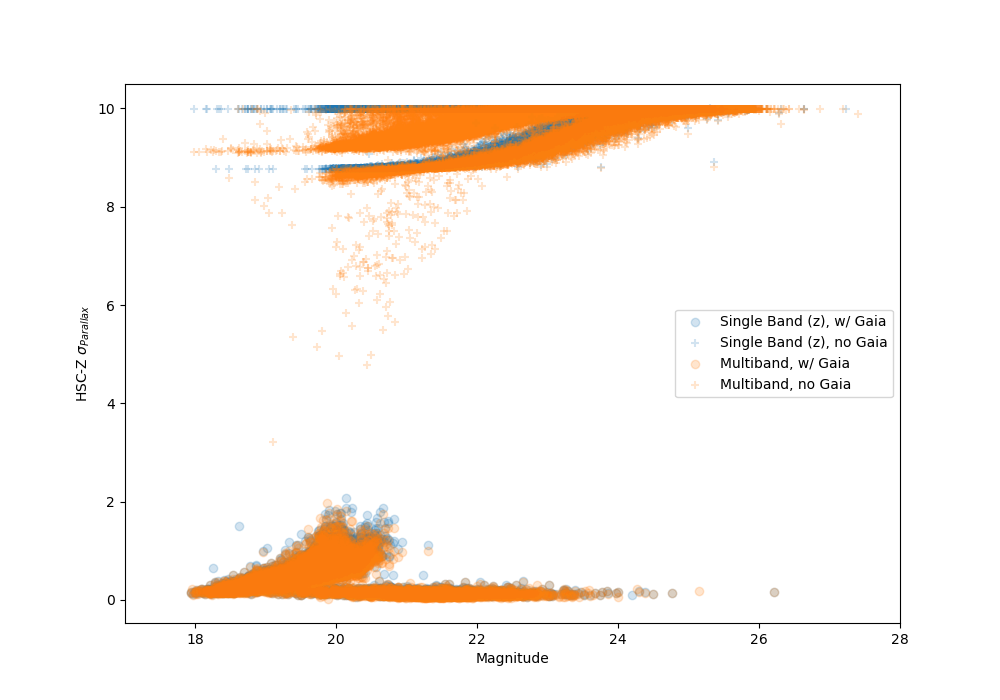

In [153]:
fig, sub = plt.subplots(1, figsize=(10, 7))
ind = single_starMags[-1] != 0
s1 = sub.scatter(single_starMags[-1][ind & single_starCats[-1]['starPMCount']], single_starCovs[-1][ind & single_starCats[-1]['starPMCount'], 4, 4]**0.5,
            alpha=0.2, label='Single Band (z), w/ Gaia')
sub.scatter(single_starMags[-1][ind & ~single_starCats[-1]['starPMCount']], single_starCovs[-1][ind & ~single_starCats[-1]['starPMCount'], 4, 4]**0.5,
            alpha=0.2, label='Single Band (z), no Gaia', color=s1.get_facecolors()[0].tolist(), marker='+')

sub.set_ylabel(f'{band} $\sigma_{{Parallax}}$')
sub.set_xlabel('Magnitude')

ind = (multi_starMags != 0) #& (multi_starCat['starPMCount'] > 0) & (multi_starCat['starDetCount'] > 1)
s2 = im = sub.scatter(multi_starMags[ind & multi_starCat['starPMCount']], multi_starCovs[ind & multi_starCat['starPMCount'], 4, 4]**0.5, 
                 alpha=0.2, label='Multiband, w/ Gaia')
im = sub.scatter(multi_starMags[ind & ~multi_starCat['starPMCount']], multi_starCovs[ind & ~multi_starCat['starPMCount'], 4, 4]**0.5, 
                 alpha=0.2, label='Multiband, no Gaia', color=s2.get_facecolors()[0].tolist(), marker='+')
sub.set_xlim(17, 28)
sub.legend()
plt.show()

In [ ]:
single_starCats[0]

## Now look at some fitStars examples:

In [74]:
single_fitStars = butler.get('gbdesAstrometricFit_fitStars', collections='u/csaunder/DM-42519_baselineRerun',
                             physical_filter='HSC-Z', instrument='HSC', skymap='hsc_rings_v1', tract=9615).to_pandas()

In [73]:
multi_fitStars = pd.DataFrame(butler.get('gbdesAstrometricMultibandFit_fitStars',
                             instrument='HSC', skymap='hsc_rings_v1', tract=9615))

In [63]:
print(single_stacked_results[9615][single_stacked_results[9615][:, 1] == 23212])
print(multiband_results[1][4][multiband_results[1][4][:,1] == 23212])

[[0.00000e+00 2.32120e+04         nan         nan 1.06070e+04 1.47910e+04
  9.97000e+01 2.00000e-01 1.67560e+01 6.07127e+00]]
[[4.20000e+01 2.32120e+04         nan         nan 2.11750e+04 3.36770e+04
  9.94000e+01 5.00000e-01 2.47560e+01 2.86354e+00]]


In [75]:
fs_1170 = single_fitStars[(single_fitStars['catalogNumber'] >= 0 * 103) & (single_fitStars['catalogNumber'] < 1 * 103)]
fm_1170 = multi_fitStars[(multi_fitStars['catalogNumber'] >= 42 * 103) & (multi_fitStars['catalogNumber'] < 43 * 103)]

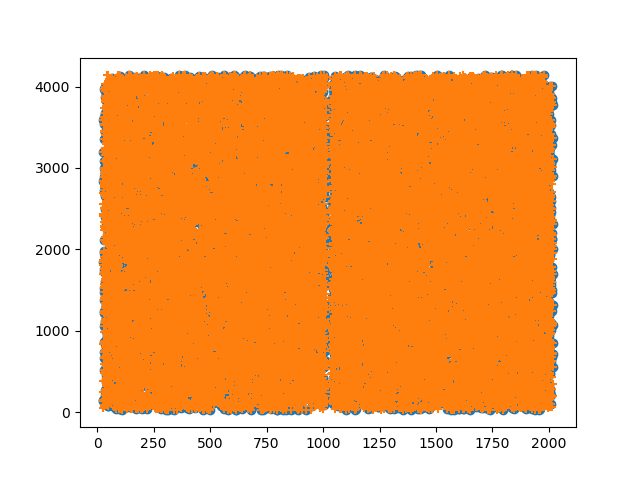

In [76]:
plt.figure()
plt.scatter(fs_1170['xpix'], fs_1170['ypix'])
plt.scatter(fm_1170['xpix'], fm_1170['ypix'], marker='+')

In [78]:
sourceCat = butler.get('sourceTable_visit', visit=23212, parameters={'columns': ['x', 'y', 'psfFlux']})

In [80]:
sourceMags = (sourceCat['psfFlux'].to_numpy() * u.nJy).to(u.ABmag)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [87]:
fs_match, ind1_fs, ind2_fs = np.intersect1d(fs_1170['xpix'], sourceCat['x'], return_indices=True)
fm_match, ind1_fm, ind2_fm = np.intersect1d(fm_1170['xpix'], sourceCat['x'], return_indices=True)
fs_mags = sourceMags[ind2_fs]
fm_mags = sourceMags[ind2_fm]
print(len(ind1))


13301


(-75.0, 75.0)

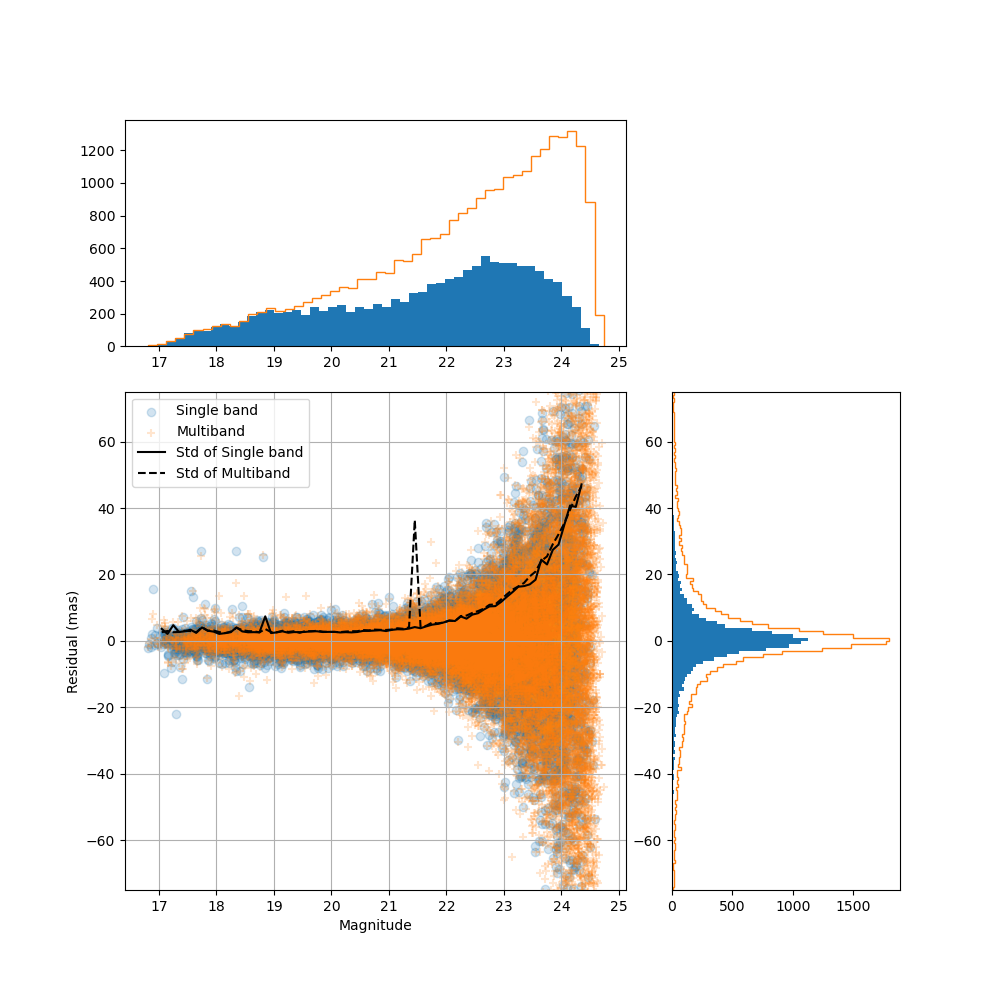

In [130]:
bin_stds_fs, bin_edges, binnumber = binned_statistic(fs_mags, fs_1170['xresw'].iloc[ind1_fs], statistic='std', bins=np.arange(17, 24.5, .1))
bin_stds_fm, bin_edges, binnumber = binned_statistic(fm_mags, fm_1170['xresw'].iloc[ind1_fm], statistic='std', bins=np.arange(17, 24.5, .1))
mosaic = """AA.
            BBC
            BBC"""
fig = plt.figure(figsize=(10, 10))
ax = fig.subplot_mosaic(mosaic)
ax['B'].scatter(fs_mags, fs_1170['xresw'].iloc[ind1_fs], alpha=0.2, label='Single band')
ax['B'].scatter(fm_mags, fm_1170['xresw'].iloc[ind1_fm], alpha=0.2, marker='+', label='Multiband')
ax['B'].plot(bin_edges[:-1] + 0.05, bin_stds_fs, color='k', label='Std of Single band')
ax['B'].plot(bin_edges[:-1] + 0.05, bin_stds_fm, color='k', linestyle='--', label='Std of Multiband')
ax['B'].set_ylim(-75, 75)
ax['B'].legend()
ax['B'].grid(True)
ax['B'].set_xlabel('Magnitude')
ax['B'].set_ylabel("Residual (mas)")

ax['A'].hist(fs_mags, bins=50)
ax['A'].hist(fm_mags, bins=50, histtype='step', facecolor='None')

bins = np.arange(-75, 76, 1)
ax['C'].hist(fs_1170['xresw'].iloc[ind1_fs], bins=bins, orientation='horizontal')
ax['C'].hist(fm_1170['xresw'].iloc[ind1_fm], bins=bins, orientation='horizontal', histtype='step', facecolor='None')
ax['C'].set_ylim(-75, 75)

(array([   9.,   15.,   33.,   50.,   78.,   99.,  107.,  123.,  137.,
         123.,  157.,  201.,  213.,  233.,  218.,  226.,  250.,  273.,
         297.,  315.,  339.,  365.,  356.,  415.,  412.,  453.,  450.,
         527.,  521.,  563.,  655.,  663.,  686.,  772.,  815.,  847.,
         905.,  959.,  964., 1035., 1050., 1071., 1162., 1206., 1286.,
        1283., 1318., 1224.,  885.,  195.]),
 array([16.80736029, 16.96591229, 17.12446428, 17.28301628, 17.44156827,
        17.60012027, 17.75867226, 17.91722426, 18.07577626, 18.23432825,
        18.39288025, 18.55143224, 18.70998424, 18.86853623, 19.02708823,
        19.18564023, 19.34419222, 19.50274422, 19.66129621, 19.81984821,
        19.9784002 , 20.1369522 , 20.2955042 , 20.45405619, 20.61260819,
        20.77116018, 20.92971218, 21.08826417, 21.24681617, 21.40536817,
        21.56392016, 21.72247216, 21.88102415, 22.03957615, 22.19812814,
        22.35668014, 22.51523214, 22.67378413, 22.83233613, 22.99088812,
        23.14944

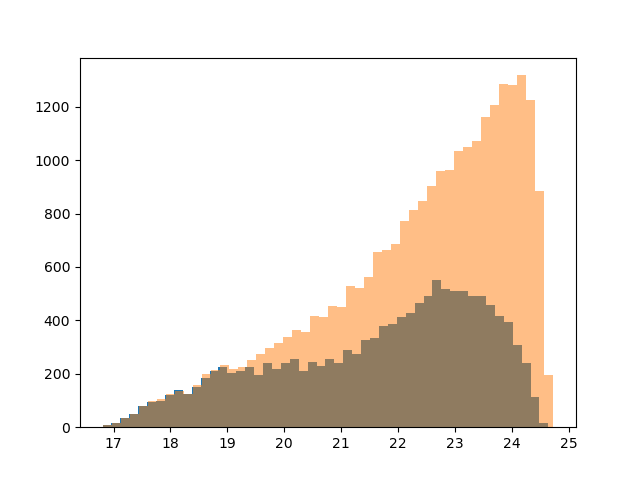

In [97]:
plt.figure()
plt.hist(fs_mags, bins=50)
plt.hist(fm_mags, alpha=0.5, bins=50)

In [94]:
fs_1170

,matchID,catalogNumber,objectNumber,clip,reserve,hasPM,color,xresw,yresw,xpix,...,sigpix,xrespix,yrespix,xworld,yworld,chisq,chisqExpected,covTotalW_00,covTotalW_11,covTotalW_01
374,187,44,5,False,False,False,-888.0,1.450404,-9.181165,836.905930,...,0.005631,-0.056322,0.009083,-2.028632,-0.767127,88.545927,1.772762,0.566216,1.079232,0.112346
390,195,44,10,False,False,False,-888.0,-2.098428,-1.821065,1843.084088,...,0.005362,-0.011262,-0.014019,-2.024740,-0.721642,10.567119,0.992489,0.534827,0.943080,0.088999
416,208,44,19,False,False,False,-888.0,-5.052271,-16.695567,114.912258,...,0.022271,-0.103183,-0.035037,-2.020776,-0.799855,18.046345,1.751933,8.954766,16.695257,1.604808
430,216,52,30,False,True,False,-888.0,-5.345367,-4.018561,447.753226,...,0.007564,-0.024736,-0.035488,-2.018218,-0.688711,31.205143,1.737604,1.105877,1.825679,0.189519
444,223,52,33,False,True,False,-888.0,-2.686904,1.345458,980.606366,...,0.010359,0.008223,-0.017810,-2.015860,-0.664551,4.493519,1.222790,2.049096,3.478085,0.361956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153722,38822,53,1,False,True,False,-888.0,-1.715435,0.438953,1901.616343,...,0.075264,-0.002626,0.011432,-0.459753,-0.606995,0.032106,1.580370,101.279702,192.220880,18.879273
153786,38838,45,2,False,False,False,-888.0,-8.152727,-2.228103,1911.503658,...,0.005603,0.013474,0.054338,-0.459276,-0.703483,114.372345,1.756609,0.597266,0.985429,0.035594
153800,38841,45,3,False,False,False,-888.0,-28.450536,-10.341441,888.717313,...,0.125239,0.063659,0.189838,-0.459159,-0.657191,2.539110,1.656914,330.436633,450.719973,46.879328
154037,38899,45,1,False,False,False,-888.0,-25.804548,-16.868282,110.920088,...,0.286309,0.104361,0.172740,-0.457682,-0.621996,0.392639,1.557229,2072.648207,2010.970079,412.453625


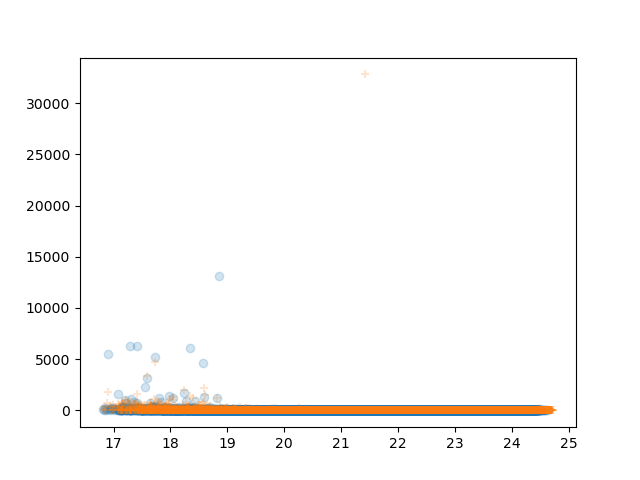

In [96]:
plt.figure()
plt.scatter(fs_mags, fs_1170['chisq'].iloc[ind1_fs], alpha=0.2)
plt.scatter(fm_mags, fm_1170['chisq'].iloc[ind1_fm], alpha=0.2, marker='+')

In [143]:
s1.to_rgba(1)

(0.267004, 0.004874, 0.329415, 1.0)